# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from joblib import dump, load
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import f1_score,recall_score,precision_score

from sklearn.naive_bayes import MultinomialNB
# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection


# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
# ROC , AUC curve
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc
# kFold
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'/home/pranay/ML datasource/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
#filtered out whole reviews

from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
# tqdm is for printing the status bar
word_counter = []
def filterised_text(text):
    preprocessed_text = []
    for sentance in tqdm(text):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        count = len(sentance.split())
        word_counter.append(count)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text

In [23]:
preprocessed_reviews = filterised_text(final['Text'].values)
final['preprocessed_reviews']  = preprocessed_reviews
preprocessed_reviews[1822]

100%|██████████| 87773/87773 [00:29<00:00, 2956.18it/s]


'taste great using air popper not great little seeds fall popping'

In [24]:
final['numbers_of_words']  = word_counter
word_counter[1822]

11

## Preprocessing Review Summary

In [25]:
preprocessed_summary = filterised_text(final['Summary'].values)
final['preprocessed_summary']  = preprocessed_summary
preprocessed_summary[1822]

100%|██████████| 87773/87773 [00:18<00:00, 4810.09it/s]


'pop corn'

### Splitting data

__We have considered 100 k points__

In [26]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61441,) (26332,) (61441,) (26332,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [27]:
##BoW

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn

# train data
X_train_bow = count_vect.fit_transform(X_train)

# test data
x_test_bow = count_vect.transform(x_test)


print('X_train_bow',X_train_bow.shape)
print('==='*10)
print('x_test_bow',x_test_bow.shape)

X_train_bow (61441, 36487)
x_test_bow (26332, 36487)


# [5] Assignment 4: Apply Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB
# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection


# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
# ROC , AUC curve
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc
# kFold
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

In [29]:
# Common Methods

# define the range, through which we are going to find alpha-hyperparameter
# alpha_values = (1e-4, 1e-3,1e-2,1e-1, 1e0,1e1)
# alpha_values =  np.geomspace(1e-3, 10)

alpha_values = (1e-4, 1e-3,1e-2,0.05,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1e0,3,5,7,9,1e1,1e2,1e3)

def finding_best_alpha(X_tr,y_tr):
    # instantiate a Multinomial Naive Bayes model
    nb = MultinomialNB()
    
    param_grid = dict(alpha=alpha_values)
    print(param_grid)
    
    #For time based splitting
    tscv = TimeSeriesSplit(n_splits=15) 
    
    # instantiate the training grid search model
    train_grid = GridSearchCV(nb, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1,verbose=10 )
    
    # fit the training data to train model
    train_grid.fit(X_tr, y_tr)

    return train_grid

    # plot a graph which show difference between validation error and training error
    
def plotAccuracyGraph(training_grid):
    alpha_range = [i for i in alpha_values]
    accuracy = [i for i in training_grid.cv_results_['mean_train_score']]
    accuracy_test = [i for i in training_grid.cv_results_['mean_test_score']]
    plt.semilogx(alpha_range, accuracy,'r',label='train_accuracy')
    plt.semilogx(alpha_range, accuracy_test,'b',label='validation_accuracy')
    plt.title('Accuracy plot')
    plt.xlabel('Alpha') 
    plt.ylabel('Accuracy')
    plt.grid('on')
    plt.legend()
    plt.show()
    
# https://www.geeksforgeeks.org/confusion-matrix-machine-learning/    
def plotConfusionMatrix(y_test,pred):
    # calculate confusion matrix
    cm =  confusion_matrix(y_test,pred)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
    # heatmap --> Plot rectangular data as a color-encoded matrix. 
    sns.heatmap(df_conf_matrix, annot=True, fmt='d')
    # give title to graph
    plt.title("Confusion Matrix")
    # mention axis label
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # show the plot
    plt.show()
    
    
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# plot AUC curve
def plotAUC_ROC(nb_optimal,X_train, y_train, X_test, y_test):
    # predict probabilities
    test_probs = nb_optimal.predict_proba(X_test)
    train_probs = nb_optimal.predict_proba(X_train)
    
    # keep probabilities for the positive outcome only
    test_probs = test_probs[:, 1]
    train_probs = train_probs[:, 1]
    
    # calculate AUC
    test_auc = roc_auc_score(y_test, test_probs)
    train_auc = roc_auc_score(y_train, train_probs)
    
    # calculate roc curve
    train_fpr, train_tpr, thresholds = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, thresholds2 = roc_curve(y_test, test_probs)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the roc curve for the model
    pyplot.plot(train_fpr, train_tpr, 'r',marker='.', label="train AUC ="+str(train_auc))
    pyplot.plot(test_fpr, test_tpr, 'b',marker='.',label="test AUC ="+str(test_auc))
    
    pyplot.legend()
    pyplot.xlabel("K: hyperparameter")
    pyplot.ylabel("AUC")
    pyplot.title("ERROR PLOTS")
    # show the plot
    pyplot.show()
    
    return train_auc, test_auc

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
    
    
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def important_features(feature_names,classifier,n=20):
    class_labels = classifier.classes_
    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]
    print(color.BOLD+"Important words in negative reviews"+color.END)
    print('\n'+color.BOLD+'\t Class Label '+color.END,class_labels[0])
    for coef, feat in topn_class1:
        print('{:.3f}'.format(coef), '\t'+feat)
    print("-----------------------------------------\n")
    print(color.BOLD+"Important words in positive reviews"+color.END)
    print('\n'+color.BOLD+'\t Class Label '+color.END,class_labels[1])
    for coef, feat in topn_class2:
        print('{:.3f}'.format(coef), '\t'+feat)



# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW

{'alpha': (0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 3, 5, 7, 9, 10.0, 100.0, 1000.0)}
Fitting 15 folds for each of 21 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1969s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 240 tas

=======Training========
0.9336869731761391
{'alpha': 0.5}
MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)


/home/pranay/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


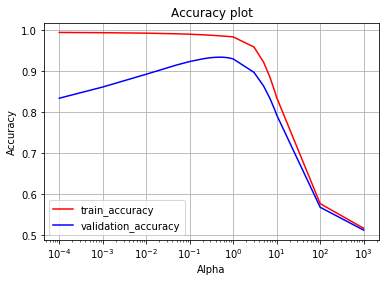

In [30]:
bow_train = finding_best_alpha(X_train_bow,y_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (bow_train.best_score_)
print (bow_train.best_params_)
print (bow_train.best_estimator_)

plotAccuracyGraph(bow_train)


Optimal best alpha is : 0.5

Confusion Matrix for Train data


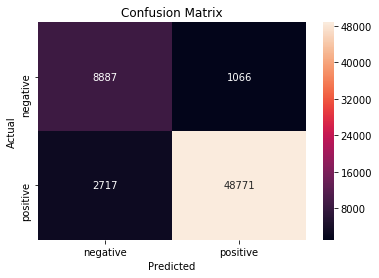


Confusion Matrix for Test data


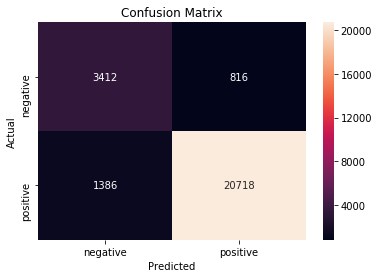

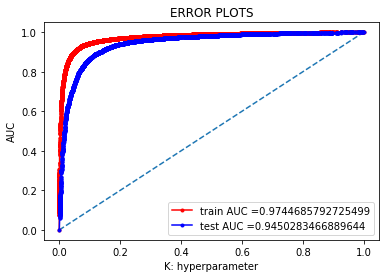


AUC (Train): 0.9744685792725499

AUC (Test): 0.9450283466889644

F1 SCORE (Train) : 0.9626646928201332

F1 SCORE (Test) : 0.9495393922727898

RECALL (Train): 0.947230422622747

RECALL (Test): 0.9372964169381107

PRECISION  (Train) : 0.9786102694784999

PRECISION  (Test) : 0.9621064363332404


In [31]:
optimal_alpha = bow_train.best_params_.get('alpha')

nb_optimal= MultinomialNB(alpha=optimal_alpha, class_prior=None, fit_prior=True)

# fitting the model
nb_optimal.fit(X_train_bow,y_train)

# predict the response
test_pred = nb_optimal.predict(x_test_bow)
train_pred = nb_optimal.predict(X_train_bow)

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(nb_optimal,X_train_bow, y_train,x_test_bow, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### [5.1.1] Top 10 important features of positive class

### [5.1.2] Top 10 important features of negative class

In [32]:
important_features(count_vect.get_feature_names(), nb_optimal, 10)

Important words in negative reviews

	 Class Label  0
16486.000 	not
5374.000 	like
4246.000 	would
4098.000 	product
4052.000 	taste
3322.000 	one
2651.000 	coffee
2627.000 	good
2498.000 	flavor
2489.000 	no
-----------------------------------------

Important words in positive reviews

	 Class Label  1
48321.000 	not
21545.000 	like
18904.000 	good
17323.000 	great
15165.000 	one
13878.000 	taste
13426.000 	coffee
12529.000 	flavor
12454.000 	love
12439.000 	would


### Feature Engineering

Till now we only consider Text review as feature, we are adding some extra feature like __review summary__ and __number of words__ in review and test our model improves efficiency or not.

We have considered on 50000 points due to memory issue.

(35000, 13) (15000, 13) (35000,) (15000,)

Confusion Matrix for Train data


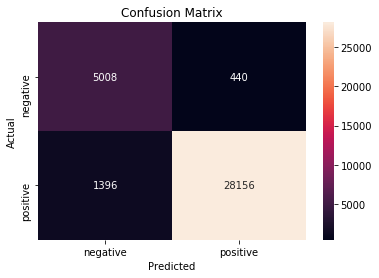


Confusion Matrix for Test data


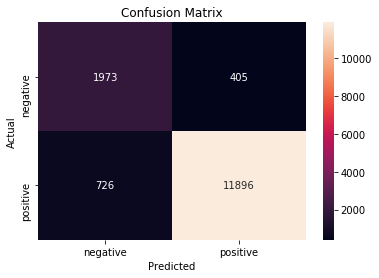

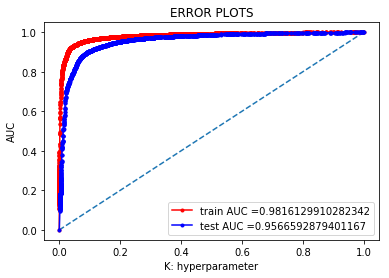


AUC (Train): 0.9816129910282342

AUC (Test): 0.9566592879401167

F1 SCORE (Train) : 0.9684253972621587

F1 SCORE (Test) : 0.9546202303093528

RECALL (Train): 0.9527612344342177

RECALL (Test): 0.9424813817144668

PRECISION  (Train) : 0.9846132326199468

PRECISION  (Test) : 0.9670758474920739


In [33]:
# https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/

X = final[:50000]
y = final['Score'][:50000]

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

mapper = DataFrameMapper([
     ('preprocessed_reviews', CountVectorizer(ngram_range=(1,3), min_df=10)),
     ('preprocessed_summary', CountVectorizer(ngram_range=(1,3), min_df=10)),
     ('numbers_of_words', None),
 ])

train_features = mapper.fit_transform(X_train)
test_features = mapper.transform(x_test)

optimal_alpha = bow_train.best_params_.get('alpha')

nb_optimal= MultinomialNB(alpha=optimal_alpha, class_prior=None, fit_prior=True)

# fitting the model
nb_optimal.fit(train_features,y_train)

# predict the response
test_pred = nb_optimal.predict(test_features)
train_pred = nb_optimal.predict(train_features)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(nb_optimal,train_features, y_train,test_features, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### [5.1.1] Top 10 important features of positive class

### [5.1.2] Top 10 important features of negative class

In [34]:
merged_features_vectorizer = mapper.features[0][1].get_feature_names() + mapper.features[1][1].get_feature_names()
important_features(merged_features_vectorizer, nb_optimal, 10)

Important words in negative reviews

	 Class Label  0
8654.000 	not
2765.000 	like
2208.000 	product
2190.000 	would
2009.000 	taste
1808.000 	one
1421.000 	good
1379.000 	no
1379.000 	food
1330.000 	not
-----------------------------------------

Important words in positive reviews

	 Class Label  1
26431.000 	not
11388.000 	like
10595.000 	good
9743.000 	great
8923.000 	tea
8144.000 	one
7372.000 	taste
6762.000 	love
6690.000 	flavor
6674.000 	product


As we can see that by consider 'review text', 'summary text' and 'number of words' in review text all together, __AUC value is changed from 0.94502 to 0.95665__

## [4.2] TF-IDF

In [35]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,3), min_df=10) #in scikit-learn

# train data
X_train_tfidf = tf_idf_vect.fit_transform(X_train)

# test data
x_test_tfidf = tf_idf_vect.transform(x_test)

print('X_train_tfidf', X_train_tfidf.shape)
print('==='*10)
print('x_test_tfidf', x_test_tfidf.shape)

(61441,) (26332,) (61441,) (26332,)
X_train_tfidf (61441, 40217)
x_test_tfidf (26332, 40217)


## [5.2] Applying Naive Bayes on TFIDF

{'alpha': (0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 3, 5, 7, 9, 10.0, 100.0, 1000.0)}
Fitting 15 folds for each of 21 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0550s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:    7.9s finished
/home/pranay/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


=======Training========
0.945188332274678
{'alpha': 0.1}
MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


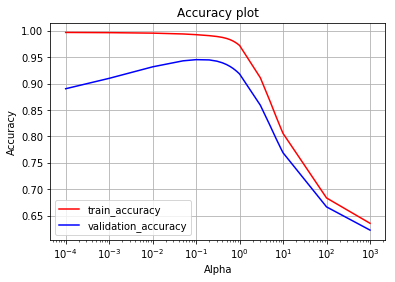

In [36]:
tfidf_train = finding_best_alpha(X_train_tfidf,y_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (tfidf_train.best_score_)
print (tfidf_train.best_params_)
print (tfidf_train.best_estimator_)

plotAccuracyGraph(tfidf_train)


Optimal best alpha is : 0.1

Confusion Matrix for Train data


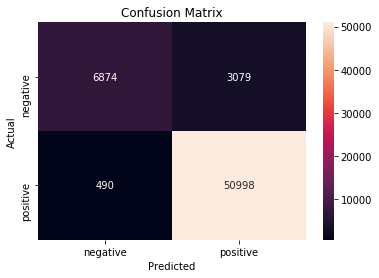


Confusion Matrix for Test data


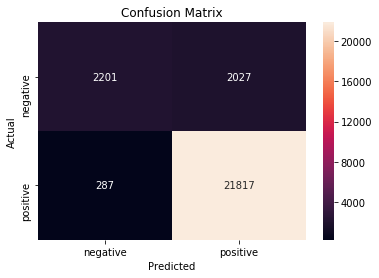

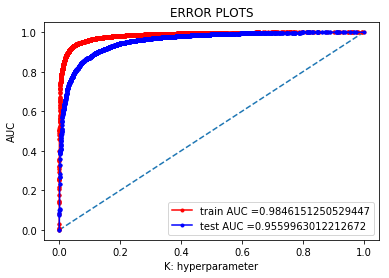


AUC (Train): 0.9846151250529447

AUC (Test): 0.9559963012212672

F1 SCORE (Train) : 0.9661914460285133

F1 SCORE (Test) : 0.9496387220336033

RECALL (Train): 0.9904832193909261

RECALL (Test): 0.9870159247195078

PRECISION  (Train) : 0.9430626698966289

PRECISION  (Test) : 0.9149890957892971


In [37]:
optimal_alpha = tfidf_train.best_params_.get('alpha')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

nb_optimal= MultinomialNB(alpha=optimal_alpha, class_prior=None, fit_prior=True)

# fitting the model
nb_optimal.fit(X_train_tfidf,y_train)

# predict the response
test_pred = nb_optimal.predict(x_test_tfidf)
train_pred = nb_optimal.predict(X_train_tfidf)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(nb_optimal,X_train_tfidf, y_train,x_test_tfidf, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### [5.2.1] Top 10 important features of positive class

### [5.2.2] Top 10 important features of negative class 

In [38]:
important_features(tf_idf_vect.get_feature_names(), nb_optimal, 10)

Important words in negative reviews

	 Class Label  0
519.547 	not
228.356 	like
212.892 	product
203.388 	would
202.627 	taste
162.527 	coffee
150.752 	one
132.950 	flavor
130.494 	no
117.575 	good
-----------------------------------------

Important words in positive reviews

	 Class Label  1
1456.513 	not
1030.260 	great
972.931 	good
923.692 	like
882.647 	coffee
817.438 	love
808.220 	tea
729.114 	one
719.204 	taste
712.064 	product


### Feature Engineering

Till now we only consider Text review as feature, we are adding some extra feature like __review summary__ and __number of words__ in review and test our model improves efficiency or not.

We have considered on 50000 points due to memory issue.

(35000, 13) (15000, 13) (35000,) (15000,)

Confusion Matrix for Train data


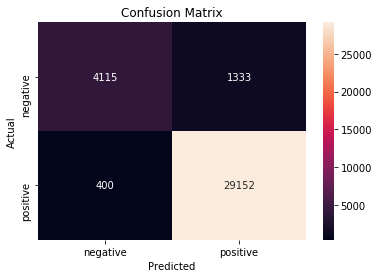


Confusion Matrix for Test data


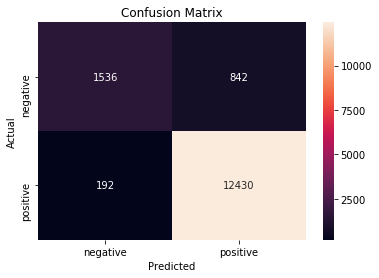

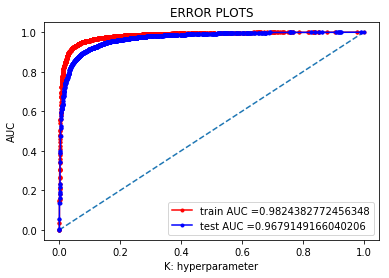


AUC (Train): 0.9824382772456348

AUC (Test): 0.9679149166040206

F1 SCORE (Train) : 0.9711344670786349

F1 SCORE (Test) : 0.9600679694137637

RECALL (Train): 0.9864645370871684

RECALL (Test): 0.9847884645856441

PRECISION  (Train) : 0.9562735771690996

PRECISION  (Test) : 0.9365581675708258


In [41]:
# https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/

X = final[:50000]
y = final['Score'][:50000]

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

mapper = DataFrameMapper([
     ('preprocessed_reviews', TfidfVectorizer(ngram_range=(1,2), min_df=10)),
     ('preprocessed_summary', TfidfVectorizer(ngram_range=(1,2), min_df=10)),
     ('numbers_of_words', None),
 ])

train_features = mapper.fit_transform(X_train)
test_features = mapper.transform(x_test)

optimal_alpha = bow_train.best_params_.get('alpha')

optimal_alpha

nb_optimal= MultinomialNB(alpha=optimal_alpha, class_prior=None, fit_prior=True)

# fitting the model
nb_optimal.fit(train_features,y_train)

# predict the response
test_pred = nb_optimal.predict(test_features)
train_pred = nb_optimal.predict(train_features)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(nb_optimal,train_features, y_train,test_features, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

In [42]:
merged_features_vectorizer = mapper.features[0][1].get_feature_names() + mapper.features[1][1].get_feature_names()
important_features(merged_features_vectorizer, nb_optimal, 10)

Important words in negative reviews

	 Class Label  0
466.440 	not
306.290 	not
134.836 	like
126.875 	product
121.272 	would
115.669 	taste
109.655 	taste
94.308 	disappointed
92.847 	one
86.631 	like
-----------------------------------------

Important words in positive reviews

	 Class Label  1
1496.994 	great
1066.364 	good
907.671 	not
845.669 	love
845.563 	best
803.768 	delicious
661.154 	tea
644.066 	great
621.736 	tea
614.086 	good


As we can see that by consider 'review text', 'summary text' and 'number of words' in review text all together, __AUC value is changed from 0.9560 to 0.96933__

# [6] Conclusions

In [63]:
import pandas as pd
from prettytable import PrettyTable

print(color.BOLD+'\t\t\t\t Naive Bayes  '+color.END)
print('\n')

print(color.BOLD+'For BOW and TFIDF, We have considered 100k points'+color.END)
print(color.BOLD+'For BOW- Additional Feature and TFIDF- Additional Feature, We have considered 50k points'+color.END)


x = PrettyTable()
x.field_names =  ['Metric','BOW','BOW-Additional Feature', 'TFIDF', 'TFIDF- Additional Features']

x.add_row(["Alpha Value ", 0.5,0.5,0.1,0.1])

x.add_row(["AUC Train ", 0.97446,0.98161,0.98461,0.98243])
x.add_row(["AUC Test ", 0.94502,0.95665,0.9560,0.96791])

x.add_row(["F1 SCORE Train ", 0.96266,0.96842,0.96619,0.97113])
x.add_row(["F1 SCORE Test ", 0.94953,0.95462,0.949638,0.96006])

x.add_row(["RECALL Train ",0.94723,0.95276,0.99048,0.9864])
x.add_row(["RECALL Test ", 0.97729,0.942481,0.9870,0.98478])

x.add_row(["PRECISION Train ", 0.97861,0.98461,0.94306,0.95627])
x.add_row(["PRECISION Test ",0.96210,0.96707,0.91498,0.93655])


print('\n')
print(x)


				 Naive Bayes  


For BOW and TFIDF, We have considered 100k points
For BOW- Additional Feature and TFIDF- Additional Feature, We have considered 50k points


+------------------+---------+------------------------+----------+----------------------------+
|      Metric      |   BOW   | BOW-Additional Feature |  TFIDF   | TFIDF- Additional Features |
+------------------+---------+------------------------+----------+----------------------------+
|   Alpha Value    |   0.5   |          0.5           |   0.1    |            0.1             |
|    AUC Train     | 0.97446 |        0.98161         | 0.98461  |          0.98243           |
|    AUC Test      | 0.94502 |        0.95665         |  0.956   |          0.96791           |
| F1 SCORE Train   | 0.96266 |        0.96842         | 0.96619  |          0.97113           |
|  F1 SCORE Test   | 0.94953 |        0.95462         | 0.949638 |          0.96006           |
|  RECALL Train    | 0.94723 |        0.95276         | 0.99048  |    